In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

In [25]:
"""
Fixed parameters
"""

block_size = None  # Number of detections in key generating basis
factor = 2 * 1e4
total_bit_sequence_length = 1200000 *factor  
# Transmittance in Bob’s side, including internal transmittance of optical components and detector efficiency
eta_bob = 4.5 / 100  # t_Bob * eta_D
y_0 = 1.7e-6 # Background rate, which includes the detector dark count and other background contributions such as the stray light from timing pulses
channel_attenuation_Z = 26  # Channel transmittance [dB], can be derived from the loss coefficient alpha measured in dB/km and the length of the fiber l in km, alpha = 0.21
channel_attenuation_X = 26
q_Z = 0.5  # Bob chooses a basis Z and X with probabilities qz
e_detector_Z = (
    3.3 / 100 
)  # e_detector, characterizes the alignment and stability, characterizes the alignment and stability, assume constant
e_detector_X = 3.3 / 100 
e_0 = 1 / 2  # error rate of the background, will assume that the background is random
epsilon_sec = 1e-10  # It's called a "epsilon_sec-secret"
epsilon_cor = 1e-15  # Secret key are identical except of probability epsilon_cor
repetition_rate = 1e9  # Pulse (symbol) repetition rate
fEC = 1.22  # Error correction effciency
epsilon_1 = epsilon_sec / 19
total_time = 0
print_counts = False

# Entropy function
def entropy(p):
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)


# Finite key correction
def n_finite_key_corrected(sign, k, p_k, n_k, n, epsilon):
    if sign == "+":
        return np.exp(k) / p_k * (n_k + np.sqrt(n / 2 * np.log(1 / epsilon)))
    elif sign == "-":
        return np.exp(k) / p_k * (n_k - np.sqrt(n / 2 * np.log(1 / epsilon)))
    else:
        raise ValueError("Invalid sign value. Must be '+' or '-'.")


# Gamma function
def gamma(a, b, c, d):
    return np.sqrt(
        (c + d)
        * (1 - b)
        * b
        / (c * d * np.log(2))
        * np.log((c + d) * 21**2 / (c * d * (1 - b) * a**2))
    )


def calculate_skr(params, factor=2* 1e4):
    mus, mud, p_mus, p_Z = params
    p_mud = 1 - p_mus
    p_X = 1 - p_Z
    q_X = 1 - q_Z
    global total_bit_sequence_length

    # Compute gain
    eta_ch_Z = np.power(10, -channel_attenuation_Z / 10)
    eta_ch_X = np.power(10, -channel_attenuation_X / 10)
    gain_Z_mus = 1 - (1 - y_0) * np.exp(-1 * mus * eta_bob * eta_ch_Z)
    gain_Z_mud = 1 - (1 - y_0) * np.exp(-1 * mud * eta_bob * eta_ch_Z)
    gain_X_mus = 1 - (1 - y_0) * np.exp(-1 * mus * eta_bob * eta_ch_X)
    gain_X_mud = 1 - (1 - y_0) * np.exp(-1 * mud * eta_bob * eta_ch_X)
    
    # Recalucalte total_bit_sequence_length to match desired nZ
    # if block_size is not None:
    #     total_bit_sequence_length = block_size / (
    #         p_Z * (p_mus * gain_Z_mus + p_mud * gain_Z_mud)
    #     )

    
    # Compute total detection events
    # n_Z_mus = p_Z * q_Z * p_mus * gain_Z_mus * total_bit_sequence_length
    # n_Z_mud = p_Z * q_Z * p_mud * gain_Z_mud * total_bit_sequence_length
    # n_X_mus = p_X * q_X * p_mus * gain_X_mus * total_bit_sequence_length
    # n_X_mud = p_X * q_X * p_mud * gain_X_mud * total_bit_sequence_length
    # n_Z = n_Z_mus + n_Z_mud
    # n_X = n_X_mus + n_X_mud
    
    n_Z_mus = 12726.7 *factor
    n_Z_mud = 1543.7 *factor
    n_X_mus = 62.2  *factor
    n_X_mud = 4.864 *factor
    n_Z = n_Z_mus + n_Z_mud
    n_X = n_X_mus + n_X_mud

    # Compute error
    # error_Z_mus = y_0 * (e_0 - e_detector_Z) + e_detector_Z * gain_Z_mus
    # error_Z_mud = y_0 * (e_0 - e_detector_Z) + e_detector_Z * gain_Z_mud
    # error_X_mus = y_0 * (e_0 - e_detector_X) + e_detector_X * gain_X_mus
    # error_X_mud = y_0 * (e_0 - e_detector_X) + e_detector_X * gain_X_mud

    # Compute total error events
    # m_Z_mus = p_Z * q_Z * p_mus * error_Z_mus * total_bit_sequence_length
    # m_Z_mud = p_Z * q_Z * p_mud * error_Z_mud * total_bit_sequence_length
    # m_X_mus = p_X * p_X * p_mus * error_X_mus * total_bit_sequence_length
    # m_X_mud = p_X * p_X * p_mud * error_X_mud * total_bit_sequence_length
    # m_Z = m_Z_mus + m_Z_mud
    # m_X = m_X_mus + m_X_mud

    m_Z_mus = 365.472 *factor
    m_Z_mud = 82.08 *factor
    m_X_mus = 2.592 *factor
    m_X_mud = 0.152 *factor
    m_Z = m_Z_mus + m_Z_mud
    m_X = m_X_mus + m_X_mud

    if print_counts:
        print("Detections:")
        print("n_Z_mus " + str(n_Z_mus))
        print("n_Z_mud " + str(n_Z_mud))
        print("n_X_mus " + str(n_X_mus))
        print("n_X_mud " + str(n_X_mud))
        print("")
        print("Errors")
        print("m_Z_mus " + str(m_Z_mus))
        print("m_Z_mud " + str(m_Z_mud))
        print("m_X_mus " + str(m_X_mus))
        print("m_X_mud " + str(m_X_mud))
        print("")
        print("Block Size: " + str(n_Z))
        print("")
        print("Rates")
        print("error_Z_mus " + str(m_Z_mus/n_Z_mus))
        print("error_Z_mud " + str(m_Z_mud/n_Z_mud))
        print("error_X_mus " + str(m_X_mus/n_X_mus))
        print("error_X_mud " + str(m_X_mud/n_X_mud))
        print("gain_Z_signal" + str(gain_Z_mus))
        print("gain_Z_decoy " + str(gain_Z_mud))
        print("gain_X_signal" + str(gain_X_mus))
        print("gain_X_decoy " + str(gain_X_mud))
        print("")
        
    # Probabilites sending vaccum and single photon states
    tau_0 = p_mus * np.exp(-mus) + p_mud * np.exp(-mud)
    tau_1 = p_mus * mus * np.exp(-mus) + p_mud * mud * np.exp(-mud)

    # Compute finite-key security bounds
    s_l_Z0 = (
        tau_0
        / (mus - mud)
        * (
            mus * n_finite_key_corrected("-", mud, p_mud, n_Z_mud, n_Z, epsilon_1)
            - mud * n_finite_key_corrected("+", mus, p_mus, n_Z_mus, n_Z, epsilon_1)
        )
    )
    s_u_Z0 = 2 * (
        tau_0 * n_finite_key_corrected("+", mus, p_mus, m_Z_mus, m_Z, epsilon_1)
        + np.sqrt(n_Z / 2 * np.log(1 / epsilon_1))
    )
    s_l_Z1 = (
        tau_1
        * mus
        / (mud * (mus - mud))
        * (
            n_finite_key_corrected("-", mud, p_mud, n_Z_mud, n_Z, epsilon_1)
            - mud**2
            / mus**2
            * n_finite_key_corrected("+", mus, p_mus, n_Z_mus, n_Z, epsilon_1)
            - (mus**2 - mud**2) / (mus**2 * tau_0) * s_u_Z0
        )
    )
    s_u_X0 = 2 * (
        tau_0 * n_finite_key_corrected("+", mud, p_mud, m_X_mud, m_X, epsilon_1)
        + np.sqrt(n_X / 2 * np.log(1 / epsilon_1))
    )
    s_l_X1 = (
        tau_1
        * mus
        / (mud * (mus - mud))
        * (
            n_finite_key_corrected("-", mud, p_mud, n_X_mud, n_X, epsilon_1)
            - mud**2
            / mus**2
            * n_finite_key_corrected("+", mus, p_mus, n_X_mus, n_X, epsilon_1)
            - (mus**2 - mud**2) / (mus**2 * tau_0) * s_u_X0
        )
    )
    v_u_X1 = (
        tau_1
        / (mus - mud)
        * (
            n_finite_key_corrected("+", mus, p_mus, m_X_mus, m_X, epsilon_1)
            - n_finite_key_corrected("-", mud, p_mud, m_X_mud, m_X, epsilon_1)
        )
    )
    phi_u_Z1 = v_u_X1 / s_l_X1 * gamma(epsilon_sec, v_u_X1 / s_l_X1, s_l_Z1, s_l_X1)

    # Error correction term
    lambda_EC = n_Z * fEC * entropy(m_Z / n_Z)

    # Compute secret key length
    secret_key_length = (
        s_l_Z0
        + s_l_Z1 * (1 - entropy(phi_u_Z1))
        - lambda_EC
        - 6 * np.log2(19 / epsilon_sec)
        - np.log2(2 / epsilon_cor)
    )
    SKR = repetition_rate * secret_key_length / total_bit_sequence_length

    # Set time it takes
    global total_time
    total_time = total_bit_sequence_length / repetition_rate

    return -SKR  # Negative for minimization

In [26]:
initial_params =  [0.20515389, 0.21344972, 0.75482631, 0.67386701] #[0.5, 0.5 / 2, 0.7, 0.9]  # mus, mud, p_mus, p_Z
bounds = [(0.3, 0.9), (0.01, 0.1), (0.5, 0.9), (0.5, 0.9)]  # bounds
attenuation = 10
channel_attenuation_Z = attenuation
channel_attenuation_X = attenuation
#print_counts = True
result = scipy.optimize.minimize(
    calculate_skr, initial_params, bounds=bounds, method="Nelder-Mead"
)
print(f"Optimized Parameter : { result.x }")
print(f"SKR : { -result.fun }")
#print_counts = False

Optimized Parameter : [0.85600984 0.01       0.9        0.5173095 ]
SKR : 380542857.5033955


C:\Users\leavi\AppData\Local\Temp\ipykernel_49612\2100904494.py:7: OptimizeWarning: Initial guess is not within the specified bounds
  result = scipy.optimize.minimize(


In [27]:
params = [0.182, 0.1, 0.81, 0.8]#[0.3, 0.1, 0.75, 0.9] # mus, mud, p_mus, p_Z
print_counts = True
skr_value = calculate_skr(params)
print("SKR: " + str(-skr_value))
print_counts = False

Detections:
n_Z_mus 254534000.0
n_Z_mud 30874000.0
n_X_mus 1244000.0
n_X_mud 97280.0

Errors
m_Z_mus 7309440.0
m_Z_mud 1641600.0
m_X_mus 51840.0
m_X_mud 3040.0

Block Size: 285408000.0

Rates
error_Z_mus 0.028716949405580394
error_Z_mud 0.05317095290535726
error_X_mus 0.04167202572347267
error_X_mud 0.03125
gain_Z_signal0.0008203633193101245
gain_Z_decoy 0.0004515980003578779
gain_X_signal0.0008203633193101245
gain_X_decoy 0.0004515980003578779

SKR: nan


C:\Users\leavi\AppData\Local\Temp\ipykernel_49612\3020280321.py:49: RuntimeWarning: invalid value encountered in log
  * np.log((c + d) * 21**2 / (c * d * (1 - b) * a**2))


In [8]:
"""
Parameter Optimization
"""

initial_params = [0.5, 0.5 / 2, 0.7, 0.9, True]  # mus, mud, p_mus, p_Z
bounds = [(0.001, 1), (0.001, 1), (0, 1), (0, 1)]  # bounds

fibre_length = np.linspace(0, 120, num=100)
attenuations = 0.21 * fibre_length
optimized_skr_values = []  # Store the optimized SKR values
optimized_param_values = []  # Store the optimized param values

for attenuation in attenuations:
    channel_attenuation_Z = attenuation
    channel_attenuation_X = attenuation
    result = scipy.optimize.minimize(
        calculate_skr, initial_params, bounds=bounds, method="Nelder-Mead"
    )
    if result.success:
        optimized_params = result.x
        optimized_param_values.append(optimized_params)
        optimized_skr = -result.fun
        optimized_skr_values.append(optimized_skr / repetition_rate)
    else:
        print("Optimization failed:", result.message)
        optimized_skr_values.append(np.nan)

optimized_skr_values = np.array(optimized_skr_values)

# Plotting with a logarithmic y-axis
plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
plt.plot(fibre_length, optimized_skr_values, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=6) # Add markers and customize line
plt.xlabel("Fiber Length (km)", fontsize=14)
plt.ylabel("Secret Key Rate per Pulse", fontsize=14)
plt.yscale("log")  # Keep log scale
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray') # Refined grid
plt.xticks(fontsize=12) # Font size for x-axis ticks
plt.yticks(fontsize=12) # Font size for y-axis ticks
plt.title("Secret Key Rate vs. Fiber Length", fontsize=16) # Add a descriptive title
plt.tight_layout() # Ensures labels don't get cut off
#plt.savefig("skr_over_distance_linear_regime.png", dpi=300) # Save as PNG with higher resolution
plt.show()

ValueError: The number of bounds is not compatible with the length of `x0`.

C:\Users\konys\AppData\Local\Temp\ipykernel_29348\3858304192.py:47: RuntimeWarning: invalid value encountered in log
  * np.log((c + d) * 21**2 / (c * d * (1 - b) * a**2))


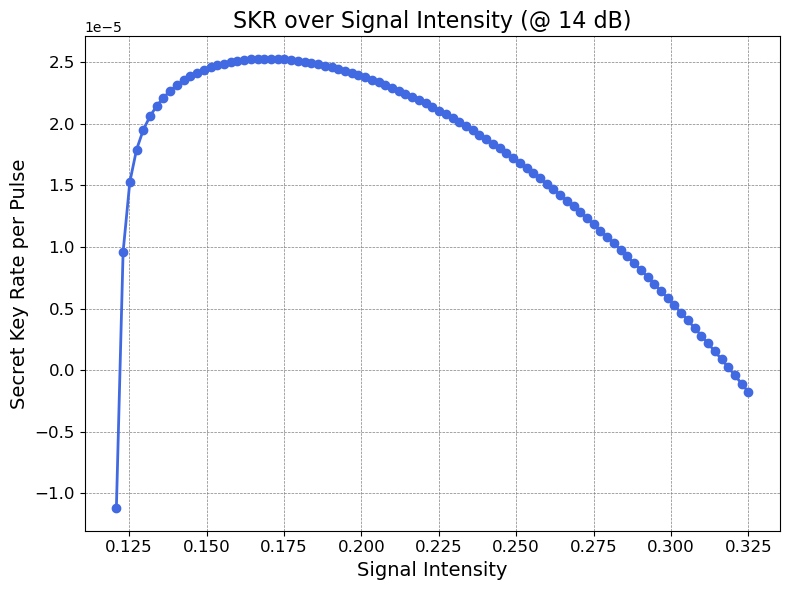

In [51]:
attenuation = 14
channel_attenuation_Z = attenuation
channel_attenuation_X = attenuation

params = [0.16943493, 0.09655856, 0.65091961, 0.98764856] # mus, mud, p_mus, p_Z

# Sweep Signal Intensity
optimum_mus = 0.16943493
delta_mus = 0.2
mus = np.linspace(optimum_mus-delta_mus, optimum_mus+delta_mus, num=100)
mus = np.linspace(0.11, 0.325, num=100)

skr_values = []
for mu in mus:
    params[0] = mu
    skr_value = calculate_skr(params)
    skr_values.append(-skr_value / repetition_rate)

skr_values = np.array(skr_values)

plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
plt.plot(mus, skr_values, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=6) # Add markers and customize line
plt.xlabel("Signal Intensity", fontsize=14)
plt.ylabel("Secret Key Rate per Pulse", fontsize=14)
#plt.yscale("log")  # Keep log scale
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray') # Refined grid
plt.xticks(fontsize=12) # Font size for x-axis ticks
plt.yticks(fontsize=12) # Font size for y-axis ticks
plt.title("SKR over Signal Intensity (@ 14 dB)", fontsize=16) # Add a descriptive title
plt.tight_layout() # Ensures labels don't get cut off
plt.savefig("skr_over_signal_intensity.png", dpi=300) # Save as PNG with higher resolution
plt.show()

C:\Users\konys\AppData\Local\Temp\ipykernel_29348\3858304192.py:47: RuntimeWarning: invalid value encountered in log
  * np.log((c + d) * 21**2 / (c * d * (1 - b) * a**2))


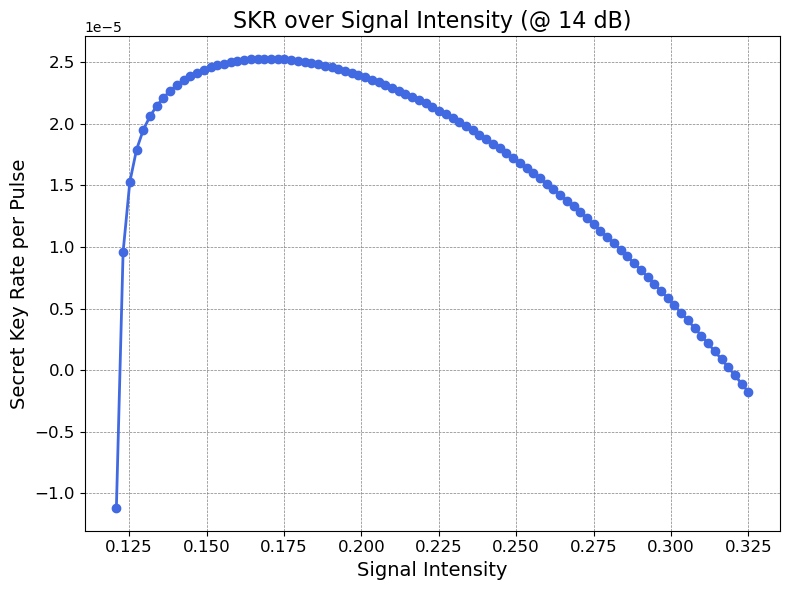

In [51]:
attenuation = 14
channel_attenuation_Z = attenuation
channel_attenuation_X = attenuation

params = [0.16943493, 0.09655856, 0.65091961, 0.98764856] # mus, mud, p_mus, p_Z

# Sweep Signal Intensity
optimum_mus = 0.16943493
delta_mus = 0.2
mus = np.linspace(optimum_mus-delta_mus, optimum_mus+delta_mus, num=100)
mus = np.linspace(0.11, 0.325, num=100)

skr_values = []
for mu in mus:
    params[0] = mu
    skr_value = calculate_skr(params)
    skr_values.append(-skr_value / repetition_rate)

skr_values = np.array(skr_values)

plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
plt.plot(mus, skr_values, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=6) # Add markers and customize line
plt.xlabel("Signal Intensity", fontsize=14)
plt.ylabel("Secret Key Rate per Pulse", fontsize=14)
#plt.yscale("log")  # Keep log scale
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray') # Refined grid
plt.xticks(fontsize=12) # Font size for x-axis ticks
plt.yticks(fontsize=12) # Font size for y-axis ticks
plt.title("SKR over Signal Intensity (@ 14 dB)", fontsize=16) # Add a descriptive title
plt.tight_layout() # Ensures labels don't get cut off
plt.savefig("skr_over_signal_intensity.png", dpi=300) # Save as PNG with higher resolution
plt.show()

C:\Users\konys\AppData\Local\Temp\ipykernel_24784\3858304192.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(k) / p_k * (n_k + np.sqrt(n / 2 * np.log(1 / epsilon)))
C:\Users\konys\AppData\Local\Temp\ipykernel_24784\3858304192.py:147: RuntimeWarning: invalid value encountered in scalar divide
  phi_u_Z1 = v_u_X1 / s_l_X1 * gamma(epsilon_sec, v_u_X1 / s_l_X1, s_l_Z1, s_l_X1)
C:\Users\konys\AppData\Local\Temp\ipykernel_24784\3858304192.py:42: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(
C:\Users\konys\AppData\Local\Temp\ipykernel_24784\3858304192.py:47: RuntimeWarning: invalid value encountered in log
  * np.log((c + d) * 21**2 / (c * d * (1 - b) * a**2))


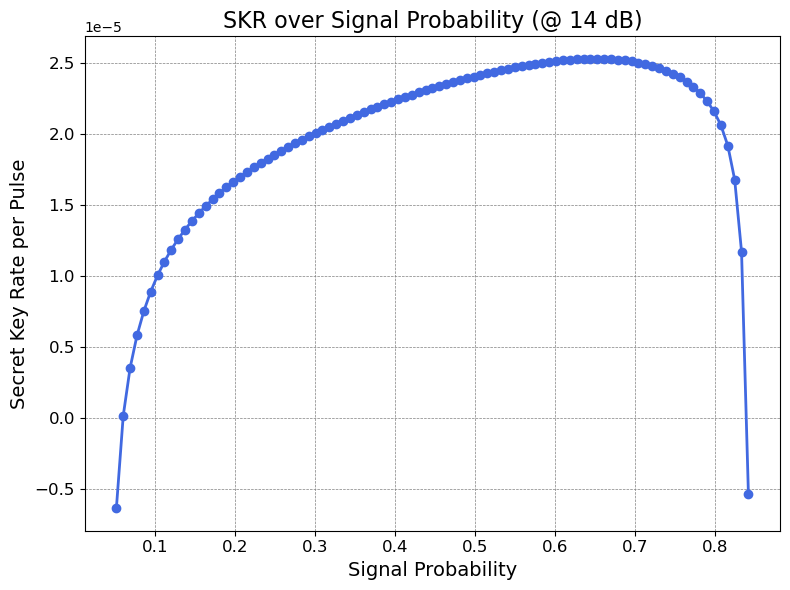

In [3]:
attenuation = 14
channel_attenuation_Z = attenuation
channel_attenuation_X = attenuation

params = [0.16943493, 0.09655856, 0.65091961, 0.98764856] # mus, mud, p_mus, p_Z

# Sweep Signal Probability
optimum_mus = 0.65091961
delta_mus = 0.3
mus = np.linspace(optimum_mus-delta_mus, optimum_mus+delta_mus, num=100)
mus = np.linspace(0, 0.85, num=100)

skr_values = []
for mu in mus:
    params[2] = mu
    skr_value = calculate_skr(params)
    skr_values.append(-skr_value / repetition_rate)

skr_values = np.array(skr_values)

plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
plt.plot(mus, skr_values, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=6) # Add markers and customize line
plt.xlabel("Signal Probability", fontsize=14)
plt.ylabel("Secret Key Rate per Pulse", fontsize=14)
#plt.yscale("log")  # Keep log scale
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray') # Refined grid
plt.xticks(fontsize=12) # Font size for x-axis ticks
plt.yticks(fontsize=12) # Font size for y-axis ticks
plt.title("SKR over Signal Probability (@ 14 dB)", fontsize=16) # Add a descriptive title
plt.tight_layout() # Ensures labels don't get cut off
plt.savefig("skr_over_signal_probability.png", dpi=300) # Save as PNG with higher resolution
plt.show()

C:\Users\konys\AppData\Local\Temp\ipykernel_29348\3858304192.py:47: RuntimeWarning: invalid value encountered in log
  * np.log((c + d) * 21**2 / (c * d * (1 - b) * a**2))
C:\Users\konys\AppData\Local\Temp\ipykernel_29348\3858304192.py:147: RuntimeWarning: invalid value encountered in scalar divide
  phi_u_Z1 = v_u_X1 / s_l_X1 * gamma(epsilon_sec, v_u_X1 / s_l_X1, s_l_Z1, s_l_X1)


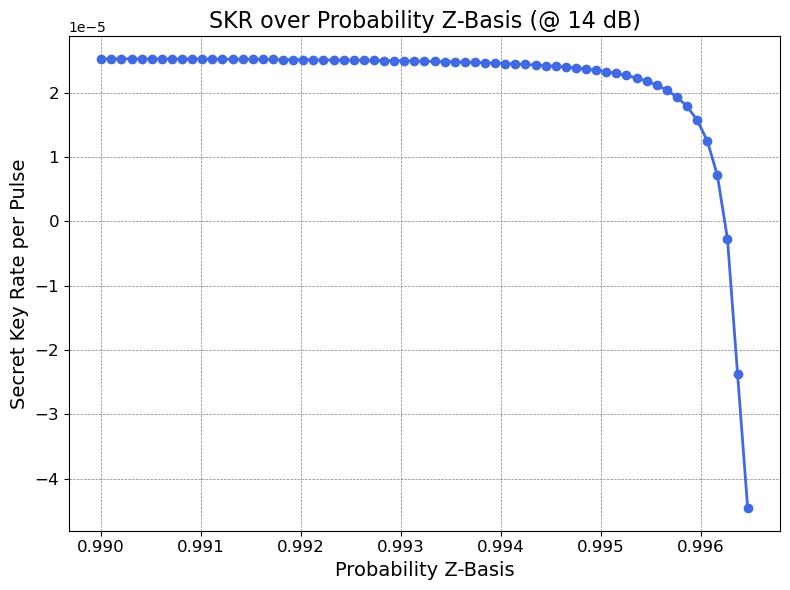

In [64]:
attenuation = 14
channel_attenuation_Z = attenuation
channel_attenuation_X = attenuation

params = [0.16943493, 0.09655856, 0.65091961, 0.98764856] # mus, mud, p_mus, p_Z

# Sweep Signal Probability
optimum_mus = 0.98764856
delta_mus = 0.04
mus = np.linspace(optimum_mus-delta_mus, optimum_mus+delta_mus, num=100)
mus = np.linspace(0.99, 1, num=100)

skr_values = []
for mu in mus:
    params[3] = mu
    skr_value = calculate_skr(params)
    skr_values.append(-skr_value / repetition_rate)

skr_values = np.array(skr_values)

plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
plt.plot(mus, skr_values, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=6) # Add markers and customize line
plt.xlabel("Probability Z-Basis", fontsize=14)
plt.ylabel("Secret Key Rate per Pulse", fontsize=14)
#plt.yscale("log")  # Keep log scale
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray') # Refined grid
plt.xticks(fontsize=12) # Font size for x-axis ticks
plt.yticks(fontsize=12) # Font size for y-axis ticks
plt.title("SKR over Probability Z-Basis (@ 14 dB)", fontsize=16) # Add a descriptive title
plt.tight_layout() # Ensures labels don't get cut off
plt.savefig("skr_over_z_basis_probabilty_2.png", dpi=300) # Save as PNG with higher resolution
plt.show()

C:\Users\konys\AppData\Local\Temp\ipykernel_29348\3858304192.py:47: RuntimeWarning: invalid value encountered in log
  * np.log((c + d) * 21**2 / (c * d * (1 - b) * a**2))
C:\Users\konys\AppData\Local\Temp\ipykernel_29348\3858304192.py:147: RuntimeWarning: invalid value encountered in scalar divide
  phi_u_Z1 = v_u_X1 / s_l_X1 * gamma(epsilon_sec, v_u_X1 / s_l_X1, s_l_Z1, s_l_X1)


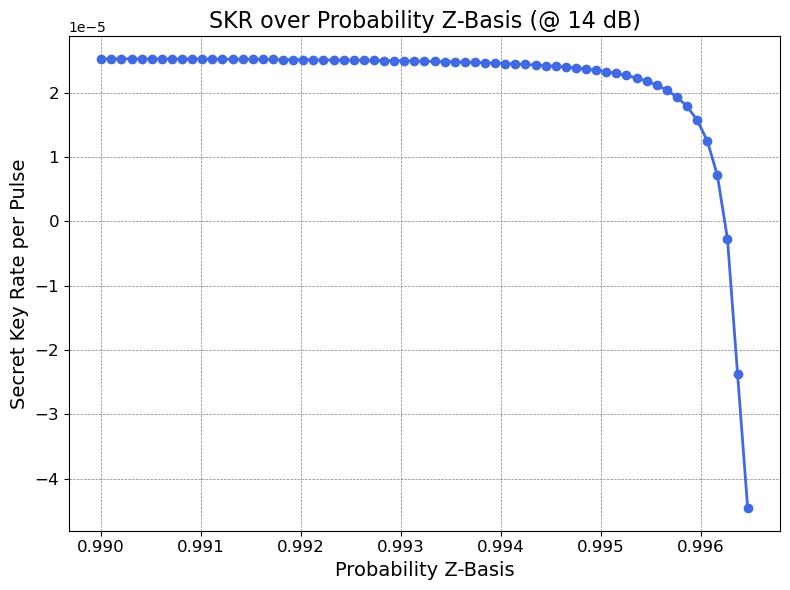

In [64]:
attenuation = 14
channel_attenuation_Z = attenuation
channel_attenuation_X = attenuation

params = [0.16943493, 0.09655856, 0.65091961, 0.98764856] # mus, mud, p_mus, p_Z

# Sweep Signal Probability
optimum_mus = 0.98764856
delta_mus = 0.04
mus = np.linspace(optimum_mus-delta_mus, optimum_mus+delta_mus, num=100)
mus = np.linspace(0.99, 1, num=100)

skr_values = []
for mu in mus:
    params[3] = mu
    skr_value = calculate_skr(params)
    skr_values.append(-skr_value / repetition_rate)

skr_values = np.array(skr_values)

plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
plt.plot(mus, skr_values, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=6) # Add markers and customize line
plt.xlabel("Probability Z-Basis", fontsize=14)
plt.ylabel("Secret Key Rate per Pulse", fontsize=14)
#plt.yscale("log")  # Keep log scale
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray') # Refined grid
plt.xticks(fontsize=12) # Font size for x-axis ticks
plt.yticks(fontsize=12) # Font size for y-axis ticks
plt.title("SKR over Probability Z-Basis (@ 14 dB)", fontsize=16) # Add a descriptive title
plt.tight_layout() # Ensures labels don't get cut off
plt.savefig("skr_over_z_basis_probabilty_2.png", dpi=300) # Save as PNG with higher resolution
plt.show()

In [33]:
for i in range(0,100,10):
    print(str(attenuations[i]) + " dB: ")
    print(str(optimized_param_values[i]))  # mus, mud, p_mus, p_Z
    print()

0.0 dB: 
[0.18544166 0.10881327 0.84170702 0.99850553]

2.333333333333333 dB: 
[0.18242902 0.10727496 0.8177458  0.99791523]

4.666666666666666 dB: 
[0.17990869 0.10587502 0.79062813 0.99707715]

7.0 dB: 
[0.17755936 0.10433043 0.76023912 0.99587478]

9.333333333333332 dB: 
[0.17516852 0.10240748 0.72662714 0.99412385]

11.666666666666666 dB: 
[0.17253775 0.09988632 0.69008615 0.99153672]

14.0 dB: 
[0.16943493 0.09655856 0.65091961 0.98764856]

16.333333333333336 dB: 
[0.16540606 0.09214134 0.60938274 0.98162828]

18.666666666666664 dB: 
[0.15967884 0.08623681 0.56570995 0.97186552]

21.0 dB: 
[0.15040491 0.07799449 0.5195462  0.95424086]



In [20]:
initial_params = [0.5, 0.5 / 2, 0.7, 0.9]
attenuation = 0
channel_attenuation_Z = attenuation
channel_attenuation_X = attenuation
calculate_skr(initial_params)

0


1321071.7051775863